In [1]:
import tensorflow as tf
import keras
import pickle
import gzip
import numpy as np
import pandas as pd
import statistics
import math
from sklearn.model_selection  import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import os,random
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np

from tensorflow.keras.utils import to_categorical
import keras.models as models
from tensorflow.keras.layers import Reshape, Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, SeparableConv2D
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras import regularizers
from keras.layers import add
from mlxtend.plotting import plot_confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


In [2]:
with open('RML2016.10a_dict.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    p = u.load()

# Extract sorted SNRs and mods
snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], p.keys())))), [1, 0])

X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(p[mod, snr])
        for i in range(p[(mod, snr)].shape[0]):
            lbl.append((mod, snr))

# Convert lists to NumPy arrays
X = np.vstack(X)
label = []
mod = []
data = []

for i in range(len(lbl)):
    label.append(lbl[i][0])
    mod.append(lbl[i][1])
    data.append(X[i])

# Create a list of tuples (or list of lists) instead of a NumPy array
arr_2 = [(label[i], mod[i], data[i]) for i in range(len(label))]

# If you need to work with NumPy arrays separately:
label_arr = np.array(label)
mod_arr = np.array(mod)
data_arr = np.array(data, dtype=object)  

In [3]:
dataset = pd.DataFrame(arr_2, columns =['Modulation Type','SNR','Values'])

dataset = dataset.set_index('Modulation Type')

In [4]:
dataset.head()


,SNR,Values
Modulation Type,,
8PSK,-20,"[[-0.007163791, -0.0024163153, 0.0006323682, 0..."
8PSK,-20,"[[0.00645143, -0.0021242828, -0.00706135, 0.01..."
8PSK,-20,"[[0.0050582555, 0.0044502057, -0.0070632556, 0..."
8PSK,-20,"[[-0.0069898423, -0.00078230025, -0.0009899994..."
8PSK,-20,"[[0.005334426, 0.009326673, -0.014855915, -0.0..."


In [5]:
dataset.shape


(220000, 2)

In [6]:
dataset = dataset.drop('WBFM',axis= 0)
dataset = dataset.drop('QPSK',axis= 0)
dataset = dataset.drop('AM-DSB',axis= 0)
dataset = dataset.drop('AM-SSB',axis= 0)
dataset = dataset.drop('CPFSK',axis= 0)


In [7]:
dataset = dataset.reset_index()

In [8]:

# Extract unique modulation types from the 'modulation_type' column
modulation_types = dataset['Modulation Type'].unique()
print("Unique Modulation Types:", modulation_types)

# Create a dictionary to store indices for each modulation type
indices_by_modulation = {}
for mod_type in modulation_types:
    indices = dataset.index[dataset['Modulation Type'] == mod_type].tolist()
    indices_by_modulation[mod_type] = indices

# Print the indices for each modulation type
for mod_type, indices in indices_by_modulation.items():
    print(f"Indices for {mod_type}: {indices[:10]}...") 

Unique Modulation Types: ['8PSK' 'BPSK' 'GFSK' 'PAM4' 'QAM16' 'QAM64']
Indices for 8PSK: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]...
Indices for BPSK: [20000, 20001, 20002, 20003, 20004, 20005, 20006, 20007, 20008, 20009]...
Indices for GFSK: [40000, 40001, 40002, 40003, 40004, 40005, 40006, 40007, 40008, 40009]...
Indices for PAM4: [60000, 60001, 60002, 60003, 60004, 60005, 60006, 60007, 60008, 60009]...
Indices for QAM16: [80000, 80001, 80002, 80003, 80004, 80005, 80006, 80007, 80008, 80009]...
Indices for QAM64: [100000, 100001, 100002, 100003, 100004, 100005, 100006, 100007, 100008, 100009]...


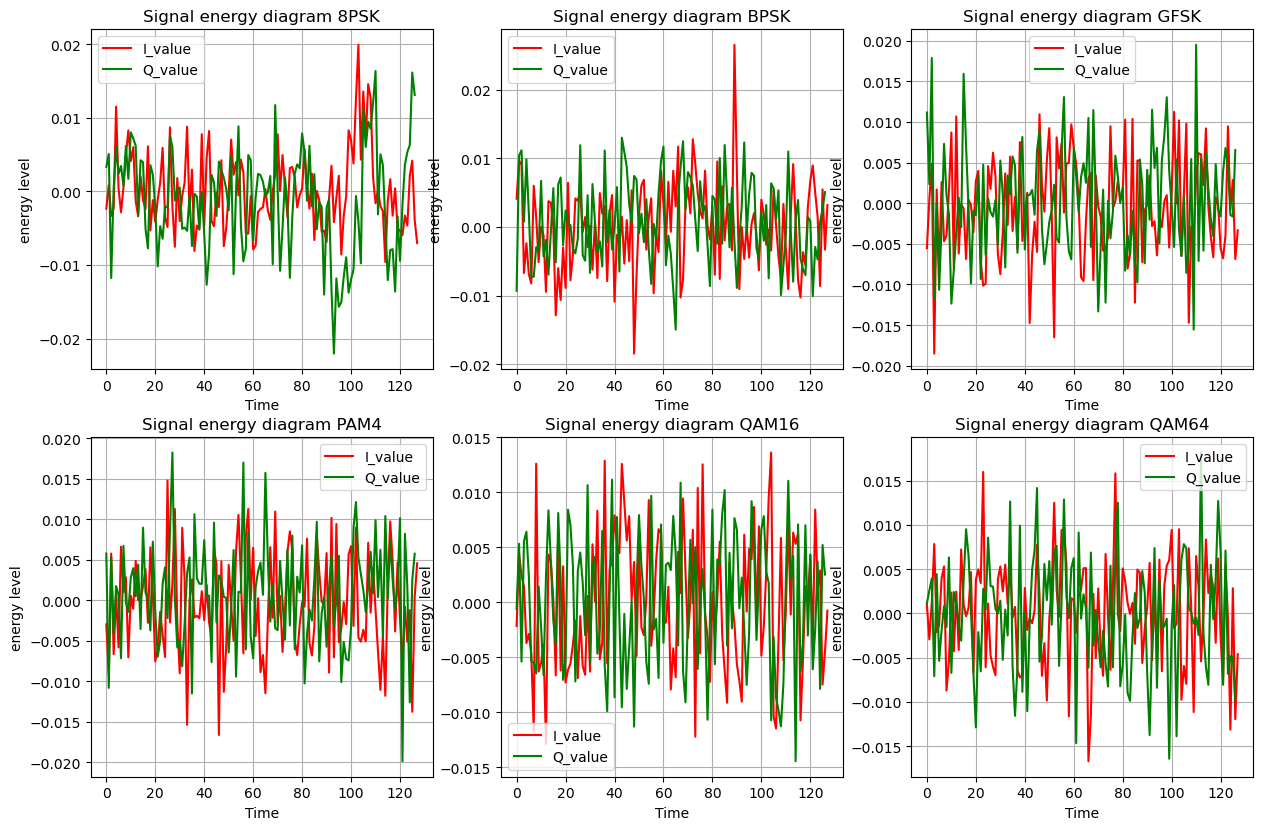

In [9]:
m1 = 10000
X1 = dataset.iat[m1,2]
X2 = dataset.iat[m1,0]
X1 = X1.flatten()

m2 = 20000
X3 = dataset.iat[m2,2]
X4 = dataset.iat[m2,0]
X3 = X3.flatten()

m3 = 40000
X5 = dataset.iat[m3,2]
X6 = dataset.iat[m3,0]
X5 = X5.flatten()

m4 = 60000
X7 = dataset.iat[m4,2]
X8 = dataset.iat[m4,0]
X7 = X7.flatten()

m5 = 80000
X9 = dataset.iat[m5,2]
X10 = dataset.iat[m5,0]
X9 = X9.flatten()

m6 = 100000
X11 = dataset.iat[m6,2]
X12 = dataset.iat[m6,0]
X11 = X11.flatten()

plt.figure(figsize = (15,15))

plt.subplot(331)

plt.plot(X1[1:129], color = 'red', label ='I_value')
plt.plot(X1[129:256], color = 'green', label ='Q_value')
plt.title(f"Signal energy diagram {X2}")
plt.xlabel('Time')
plt.grid()
plt.ylabel('energy level')
plt.legend()

plt.subplot(332)

plt.plot(X3[1:129], color = 'red', label ='I_value')
plt.plot(X3[129:256], color = 'green', label ='Q_value')
plt.title(f"Signal energy diagram {X4}")
plt.xlabel('Time')
plt.grid()
plt.ylabel('energy level')
plt.legend()

plt.subplot(333)

plt.plot(X5[1:129], color = 'red', label ='I_value')
plt.plot(X5[129:256], color = 'green', label ='Q_value')
plt.title(f"Signal energy diagram {X6}")
plt.xlabel('Time')
plt.grid()
plt.ylabel('energy level')
plt.legend()

plt.subplot(334)

plt.plot(X7[1:129], color = 'red', label ='I_value')
plt.plot(X7[129:256], color = 'green', label ='Q_value')
plt.title(f"Signal energy diagram {X8}")
plt.xlabel('Time')
plt.grid()
plt.ylabel('energy level')
plt.legend()

plt.subplot(335)

plt.plot(X9[1:129], color = 'red', label ='I_value')
plt.plot(X9[129:256], color = 'green', label ='Q_value')
plt.title(f"Signal energy diagram {X10}")
plt.xlabel('Time')
plt.grid()
plt.ylabel('energy level')
plt.legend()

plt.subplot(336)

plt.plot(X11[1:129], color = 'red', label ='I_value')
plt.plot(X11[129:256], color = 'green', label ='Q_value')
plt.title(f"Signal energy diagram {X12}")
plt.xlabel('Time')
plt.grid()
plt.ylabel('energy level')
plt.legend()

In [10]:
def gaussian_noise(mu,sigma):
    noise = np.random.normal(mu,sigma,[2,128])
    return noise

def noise_added(signal, Gnoise):
    signal = signal + Gnoise
    return signal

def sd_calc(data):
    meanValue = statistics.mean(data)
    var = statistics.variance(data,meanValue)
    sd = math.sqrt(var)
    return sd

In [11]:
array_noisesignal = []
noise_signal = []
for i in range(len(dataset)):
    temp = dataset.iat[i,2]
    std = sd_calc(temp[0])
    n1 = gaussian_noise(0, std)
    noise_signal.append(n1)
    final = noise_added(temp,n1)
    array_noisesignal.append(final)

array_noisesignal = np.array(array_noisesignal)
noise_signal = np.array(noise_signal)
dataset_2 = dataset.copy()

dataset['data'] = array_noisesignal.tolist()
dataset_2['noise'] = noise_signal.tolist()

dataset = dataset.drop(columns = ['Values'])
dataset_2 = dataset_2.drop(columns = ['Values'])

labels_noise = np.zeros([120000,1])
labels_signal = np.ones([120000,1])

dataset['labels'] = labels_signal.tolist()
dataset_2['labels'] = labels_noise.tolist()

dataset['labels'] = labels_signal.astype('int64')
dataset_2['labels'] = labels_noise.astype('int64')

dataset_2.columns = dataset.columns
df = pd.concat([dataset, dataset_2], ignore_index=True)

In [12]:
print(dataset.columns)

Index(['Modulation Type', 'SNR', 'data', 'labels'], dtype='object')


In [13]:
df = df.sample(frac=1).reset_index(drop=True)

In [14]:
df 

,Modulation Type,SNR,data,labels
0,QAM16,8,"[[-0.005928041569366957, 0.010573288174070643,...",1
1,PAM4,-8,"[[0.00262965750948052, 0.005859948752381933, 0...",1
2,8PSK,4,"[[-0.013996810661114724, -0.006866876840299791...",1
3,GFSK,-6,"[[0.005412717190672554, 0.01235271131580832, 0...",1
4,BPSK,16,"[[0.003495400293367134, 1.2715299555911275e-05...",1
...,...,...,...,...
239995,PAM4,0,"[[-0.0014111156628070134, 0.00332588168724819,...",1
239996,QAM64,-10,"[[-0.0030462120523677616, -0.00232812850518478...",0
239997,PAM4,12,"[[0.0002838230733649278, 0.00858753321910542, ...",0
239998,QAM64,-14,"[[-0.003253746674802956, -0.006263119025906177...",0


In [15]:
y = list(df['labels'])
X = df['data']

np.random.seed(258)
n_examples = X.shape[0]
n_train = n_examples * 0.70
train_idx = np.random.choice(range(0,n_examples), size = int(n_train), replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test = X[test_idx]

In [16]:
X_train = np.array(X_train)

for i in range(len(X_train)):
    X_train[i] = np.array(X_train[i])

X_train_final =[]
for i in X_train:
    X_train_final.append(i)

X_train_final = np.array(X_train_final)
X_train_final.shape 

(168000, 2, 128)

In [17]:
X_test = np.array(X_test)

for i in range(len(X_test)):
    X_test[i]= np.array(X_test[i])
    
X_test_final = []
for i in X_test:
    X_test_final.append(i)

X_test_final = np.array(X_test_final)
X_test_final.shape

(72000, 2, 128)

In [18]:
y_train_final = []
y_test_final = []
for i in train_idx:
    y_train_final.append(y[i])
for j in test_idx:
    y_test_final.append(y[j])

y_train_final = np.array(y_train_final)
y_test_final = np.array(y_test_final)

In [19]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

# Reshaping the data
X_train_flat = X_train_final.reshape((X_train_final.shape[0], -1))
X_test_flat = X_test_final.reshape((X_test_final.shape[0], -1))

# Scaling the features - You can try MinMaxScaler or StandardScaler
scaler = MinMaxScaler()  # Try MinMaxScaler instead of StandardScaler
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# SVM - Tuned Hyperparameters
# You can adjust the kernel, C, gamma, and max_iter for better performance
svm = SVC(kernel='rbf', C=1.0, gamma='scale', max_iter=1000)  # Kernel = rbf, C = 1, gamma = scale (auto tuning)
svm.fit(X_train_scaled, y_train_final)

# Prediction
y_pred_svm = svm.predict(X_test_scaled)
svm_accuracy = accuracy_score(y_test_final, y_pred_svm)
print(f"SVM Accuracy (with rbf kernel): {svm_accuracy * 100:.2f}%")

# Random Forest - For Comparison
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)  
rf.fit(X_train_scaled, y_train_final)
y_pred_rf = rf.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test_final, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")




C:\Users\THINKPAD\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM Accuracy (with rbf kernel): 97.60%
Random Forest Accuracy: 96.29%


<Figure size 900x900 with 0 Axes>

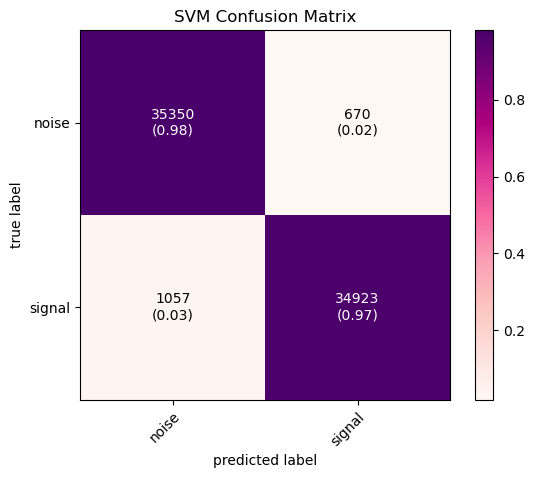

<Figure size 900x900 with 0 Axes>

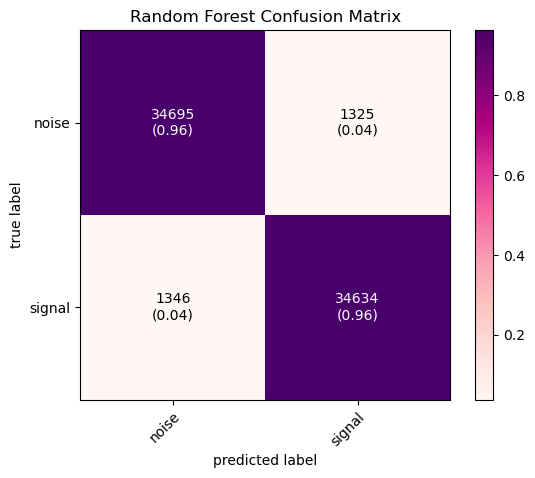

In [20]:
cm_svm = confusion_matrix(y_test_final, y_pred_svm)

# Random Forest Model
cm_rf = confusion_matrix(y_test_final, y_pred_rf)

# Plot SVM Confusion Matrix
plt.figure(figsize=(9, 9))
class_names = ['noise', 'signal']
fig, ax = plot_confusion_matrix(conf_mat=cm_svm, cmap='RdPu', class_names=class_names, colorbar=True, show_normed=True)
plt.title("SVM Confusion Matrix")
plt.show()

plt.figure(figsize=(9, 9))
fig, ax = plot_confusion_matrix(conf_mat=cm_rf, cmap='RdPu', class_names=class_names, colorbar=True, show_normed=True)
plt.title("Random Forest Confusion Matrix")
plt.show()

In [21]:
import pandas as pd

svm_predictions = svm.predict(X_test_scaled)
rf_predictions = rf.predict(X_test_scaled)

data_snr_svm = df.loc[test_idx, :].copy()  
data_snr_svm['svm_prediction'] = svm_predictions  

data_snr_rf = df.loc[test_idx, :].copy()  
data_snr_rf['rf_prediction'] = rf_predictions 

data_snr_svm = data_snr_svm.reset_index(drop=True)
data_snr_rf = data_snr_rf.reset_index(drop=True)


In [29]:
data_snr_rf

,Modulation Type,SNR,data,labels,rf_prediction
0,8PSK,-14,"[[-0.001658599304382858, 0.002136647173877462,...",1,1
1,QAM16,10,"[[0.0012090630858864985, 0.005266634175903317,...",0,0
2,8PSK,0,"[[0.0028170252469037348, -0.003213105613174172...",1,1
3,8PSK,-10,"[[0.007484378064246108, 0.0019158729321871776,...",1,0
4,QAM16,2,"[[-3.330820991306497e-05, 0.007955975339809353...",0,0
...,...,...,...,...,...
71995,PAM4,18,"[[0.0008001249517279157, 0.0026720358938919385...",1,1
71996,8PSK,-8,"[[-0.0014865986133250535, -0.00111197971009178...",0,0
71997,QAM64,14,"[[0.006086248279302074, 0.00634935033330455, -...",0,0
71998,GFSK,18,"[[0.00761937731869413, 0.008888408505005522, 0...",1,1


In [30]:
data_snr_rf.to_csv('dataset_rf.csv', index=False)

In [31]:
data_snr_svm

,Modulation Type,SNR,data,labels,svm_prediction
0,8PSK,-14,"[[-0.001658599304382858, 0.002136647173877462,...",1,1
1,QAM16,10,"[[0.0012090630858864985, 0.005266634175903317,...",0,0
2,8PSK,0,"[[0.0028170252469037348, -0.003213105613174172...",1,1
3,8PSK,-10,"[[0.007484378064246108, 0.0019158729321871776,...",1,1
4,QAM16,2,"[[-3.330820991306497e-05, 0.007955975339809353...",0,0
...,...,...,...,...,...
71995,PAM4,18,"[[0.0008001249517279157, 0.0026720358938919385...",1,1
71996,8PSK,-8,"[[-0.0014865986133250535, -0.00111197971009178...",0,0
71997,QAM64,14,"[[0.006086248279302074, 0.00634935033330455, -...",0,0
71998,GFSK,18,"[[0.00761937731869413, 0.008888408505005522, 0...",1,1


In [32]:
data_snr_svm.to_csv('dataset_svm.csv', index=False)

In [33]:
in_shp =[2,128]

In [34]:
import keras.models as models
drop_rate_1 = 0.3

cnn = keras.models.Sequential()
cnn.add(Reshape(in_shp+[1], input_shape=in_shp))

cnn.add(Conv2D(128,(1,8),padding='valid', activation="relu", name="conv1",kernel_initializer='glorot_uniform',data_format ="channels_last"))
cnn.add(MaxPooling2D(pool_size=(2,2), strides=None, padding="valid" , data_format=None))

cnn.add(Conv2D(96,(1,4),padding='valid', activation="relu", name="conv2",kernel_initializer='glorot_uniform',data_format ="channels_last"))

cnn.add(Conv2D(64,(1,8),padding='valid', activation="relu", name="conv3",kernel_initializer='glorot_uniform',data_format ="channels_last"))
cnn.add(MaxPooling2D(pool_size=(1,1), strides=None, padding="valid" , data_format=None))

cnn.add(Conv2D(32,(1,8),padding='valid', activation="relu", name="conv4",kernel_initializer='glorot_uniform',data_format ="channels_last"))

cnn.add(Flatten())
cnn.add(Dense(125, activation='relu', kernel_initializer = 'he_normal'))
cnn.add(Dense(50, activation='relu', kernel_initializer = 'he_normal'))
cnn.add(Dropout(drop_rate_1))
cnn.add(Dense(5, activation='relu', kernel_initializer = 'he_normal'))
cnn.add(Dense(1, kernel_initializer = 'he_normal'))

cnn.add(Activation('sigmoid'))

cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(cnn.summary())

C:\Users\THINKPAD\anaconda3\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)                  │ (None, 2, 128, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 2, 121, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 60, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 1, 57, 96)           │          49,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 1, 50, 64)           │          49,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 50, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4 (Conv2D)                       │ (None, 1, 43, 32)           │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1376)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 125)                 │         172,125 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 50)                  │           6,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 5)                   │             255 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 294,718 (1.12 MB)

 Trainable params: 294,718 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

None


In [35]:
nb_epoch = 50
batch_size = 500

In [36]:
HIS = cnn.fit(
    X_train_final,
    y_train_final,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_split=0.15,
    callbacks=[
        keras.callbacks.ModelCheckpoint('model_d1.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
    ]
)


Epoch 1/50

Epoch 1: val_loss improved from inf to 0.04510, saving model to model_d1.keras
286/286 - 102s - 357ms/step - accuracy: 0.9433 - loss: 0.1702 - val_accuracy: 0.9865 - val_loss: 0.0451
Epoch 2/50

Epoch 2: val_loss did not improve from 0.04510
286/286 - 74s - 260ms/step - accuracy: 0.9838 - loss: 0.0532 - val_accuracy: 0.9808 - val_loss: 0.0591
Epoch 3/50

Epoch 3: val_loss improved from 0.04510 to 0.03930, saving model to model_d1.keras
286/286 - 68s - 237ms/step - accuracy: 0.9852 - loss: 0.0481 - val_accuracy: 0.9880 - val_loss: 0.0393
Epoch 4/50

Epoch 4: val_loss did not improve from 0.03930
286/286 - 58s - 202ms/step - accuracy: 0.9843 - loss: 0.0490 - val_accuracy: 0.9565 - val_loss: 0.1040
Epoch 5/50

Epoch 5: val_loss improved from 0.03930 to 0.03913, saving model to model_d1.keras
286/286 - 91s - 319ms/step - accuracy: 0.9855 - loss: 0.0458 - val_accuracy: 0.9878 - val_loss: 0.0391
Epoch 6/50

Epoch 6: val_loss did not improve from 0.03913
286/286 - 83s - 290ms/step

In [37]:
cnn.load_weights('model_d1.keras')

In [38]:
scscore = cnn.evaluate(X_test_final, y_test_final, batch_size=batch_size)
print(cnn.metrics_names)
print(scscore)

144/144 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - accuracy: 0.9890 - loss: 0.0339
['loss', 'compile_metrics']
[0.03438775613903999, 0.9889861345291138]


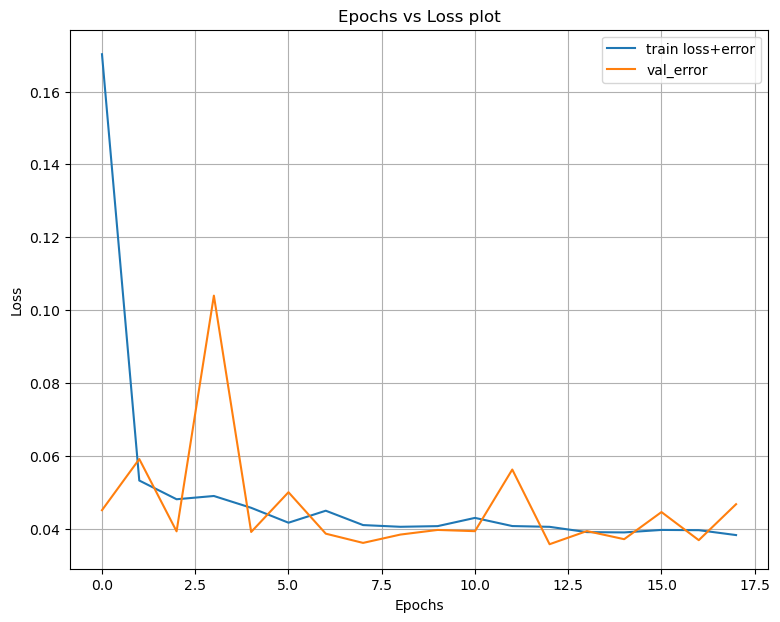

In [39]:
plt.figure(figsize=(9,7))
plt.title('Training performance')
plt.plot(HIS.epoch, HIS.history['loss'],label='train loss+error')
plt.plot(HIS.epoch, HIS.history['val_loss'],label='val_error')
plt.title("Epochs vs Loss plot")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

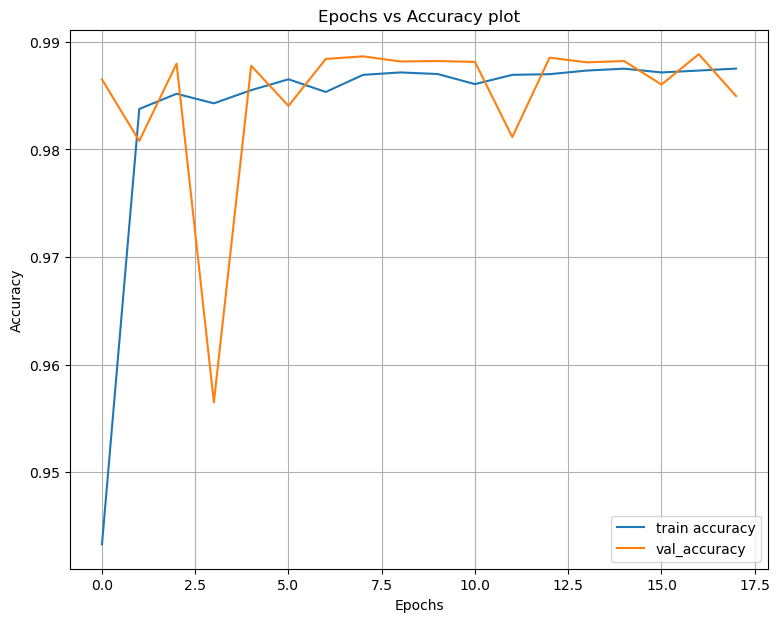

In [40]:
plt.figure(figsize=(9,7))
plt.title('Training performance')
plt.plot(HIS.epoch, HIS.history['accuracy'],label='train accuracy')
plt.plot(HIS.epoch, HIS.history['val_accuracy'],label='val_accuracy')
plt.title("Epochs vs Accuracy plot")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

In [41]:
classes=['noise','signal']
test_Y_hat = cnn.predict(X_test_final, batch_size=batch_size)

prediction=[]
for i in range(len(test_Y_hat)):
    prediction.append(list(test_Y_hat[i]))

final_prediction = []
for j in range(len(prediction)):
    final_prediction.append(round(prediction[j][0]))

144/144 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step


<Figure size 900x900 with 0 Axes>

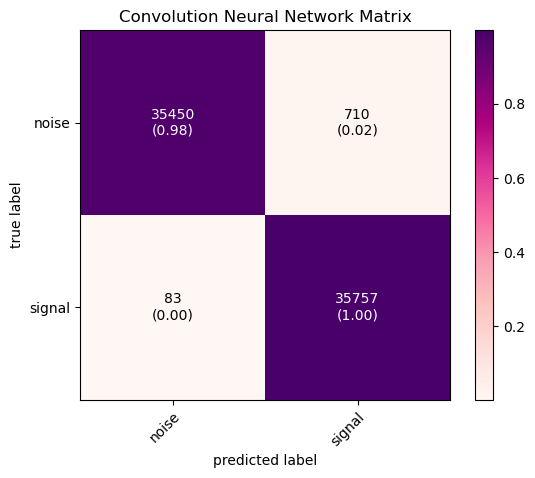

In [71]:
from mlxtend.plotting import plot_confusion_matrix
plt.figure(figsize =(9,9))
cm = confusion_matrix(y_test_final, final_prediction)
class_names = ['noise','signal']
fig, ax = plot_confusion_matrix(conf_mat=cm, cmap='RdPu', class_names=class_names,colorbar =True, show_normed=True)
plt.title("Convolution Neural Network Matrix")
plt.show()

In [43]:
data_snr = df.loc[test_idx, :]
data_snr['prediction'] = final_prediction

data_snr = data_snr.reset_index()
data_snr

,index,Modulation Type,SNR,data,labels,prediction
0,1,8PSK,-14,"[[-0.001658599304382858, 0.002136647173877462,...",1,1
1,3,QAM16,10,"[[0.0012090630858864985, 0.005266634175903317,...",0,0
2,131076,8PSK,0,"[[0.0028170252469037348, -0.003213105613174172...",1,1
3,131079,8PSK,-10,"[[0.007484378064246108, 0.0019158729321871776,...",1,1
4,131080,QAM16,2,"[[-3.330820991306497e-05, 0.007955975339809353...",0,0
...,...,...,...,...,...,...
71995,131036,PAM4,18,"[[0.0008001249517279157, 0.0026720358938919385...",1,1
71996,131040,8PSK,-8,"[[-0.0014865986133250535, -0.00111197971009178...",0,0
71997,131055,QAM64,14,"[[0.006086248279302074, 0.00634935033330455, -...",0,0
71998,131057,GFSK,18,"[[0.00761937731869413, 0.008888408505005522, 0...",1,1


In [44]:
data_snr.to_csv('dataset_cnn.csv', index=False)

In [45]:
snr = [-20, -16, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16]
final_acc=[]
for i in range(len(snr)):
    correct = 0
    wrong = 0
    for k in range(len(data_snr)):
      if(data_snr['SNR'][k]== snr[i]):
        if(data_snr['labels'][k]== data_snr['prediction'][k]):
            correct +=1
        else:
            wrong +=1
    acc= correct/(correct+wrong)
    final_acc.append(acc)

In [46]:
final_acc

[0.9966685174902832,
 0.9949166902005083,
 0.9955282280603689,
 0.9983103351168685,
 0.9972383319524993,
 0.9977697240033454,
 0.995445488186735,
 0.9894678492239468,
 0.9831697054698457,
 0.9803704727674869,
 0.9796552698502402,
 0.9836065573770492,
 0.9795749378967706,
 0.982451403887689,
 0.98352687010532,
 0.9858882125069175,
 0.9826206896551725]

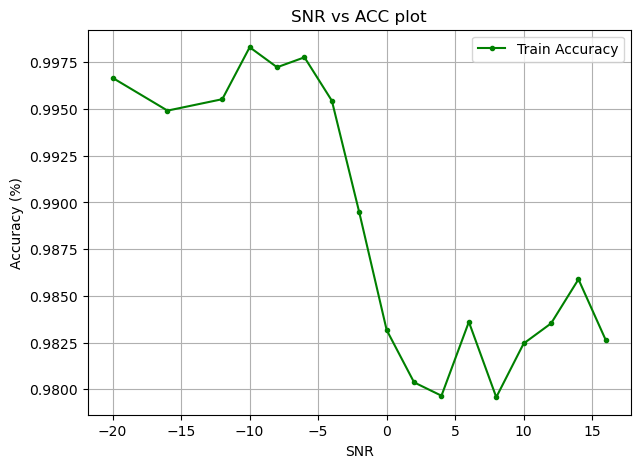

In [47]:
plt.figure(figsize=(7,5))
plt.plot(snr,final_acc,'g',label ="Train Accuracy", marker =".")
plt.title("SNR vs ACC plot")
plt.xlabel("SNR")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()

In [48]:
snr = [-20, -16, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16]
final_acc_cm = []

for i in range(len(snr)):
    correct_0 = 0
    wrong_0 = 0
    correct_1 = 0
    wrong_1 = 0

    for k in range(len(data_snr)):
        if data_snr['SNR'][k] == snr[i]:
            if data_snr['labels'][k] == data_snr['prediction'][k]:
                if data_snr['labels'][k] == 0:
                    correct_0 += 1
                else:
                    correct_1 += 1
            else:
                if data_snr['labels'][k] == 0:
                    wrong_0 += 1
                else:
                    wrong_1 += 1

    TP = correct_1 / (correct_1 + wrong_1) if (correct_1 + wrong_1) > 0 else 0
    TN = correct_0 / (correct_0 + wrong_0) if (correct_0 + wrong_0) > 0 else 0
    FP = wrong_1 / (wrong_1 + correct_0) if (wrong_1 + correct_0) > 0 else 0
    FN = wrong_0 / (wrong_0 + correct_1) if (wrong_0 + correct_1) > 0 else 0

    acc = (correct_0 + correct_1) / (correct_0 + wrong_0 + correct_1 + wrong_1) if (correct_0 + wrong_0 + correct_1 + wrong_1) > 0 else 0
    final_acc_cm.append([[TN, FN], [FP, TP]])

# Now final_acc_cm contains the confusion matrices for each SNR value


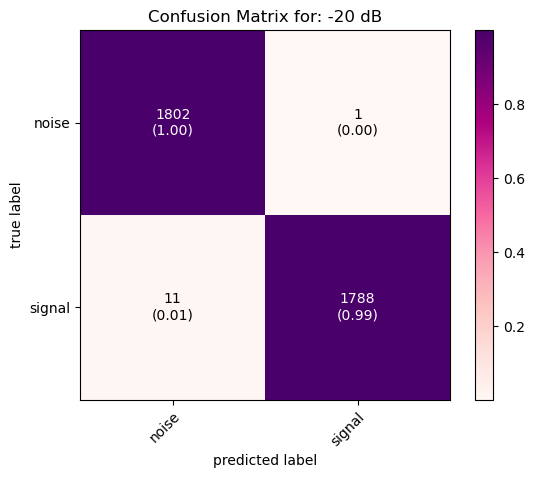

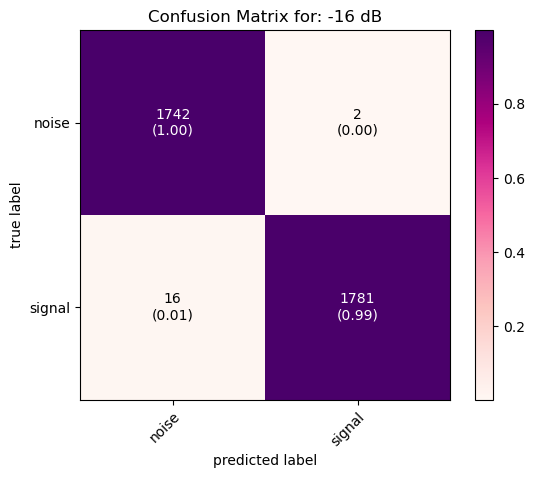

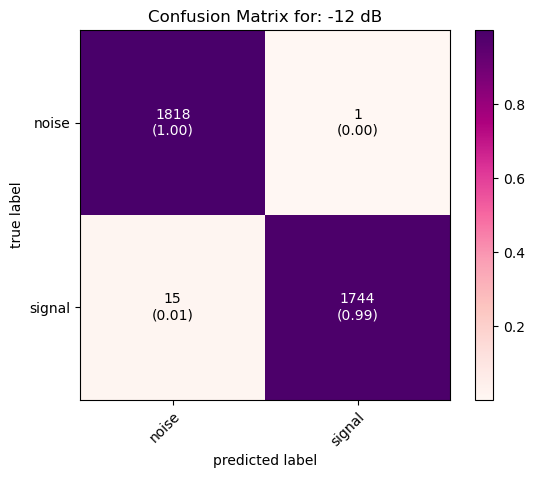

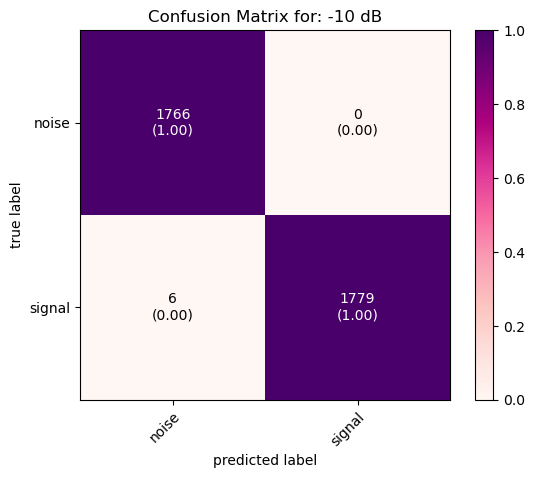

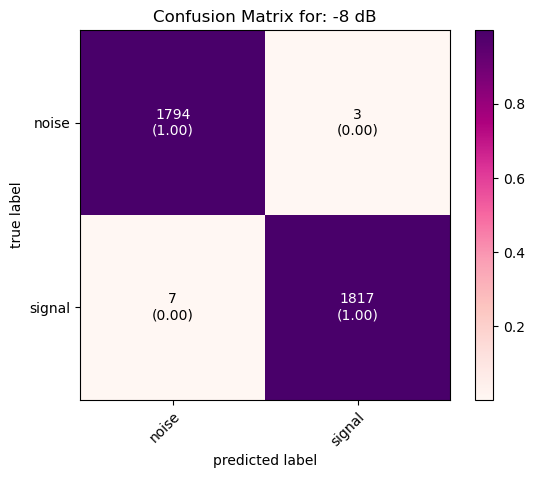

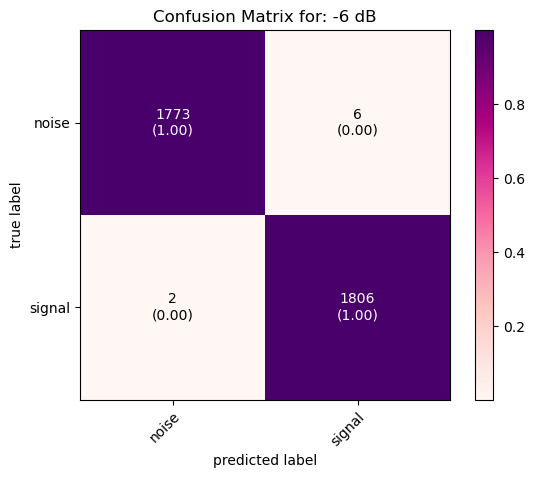

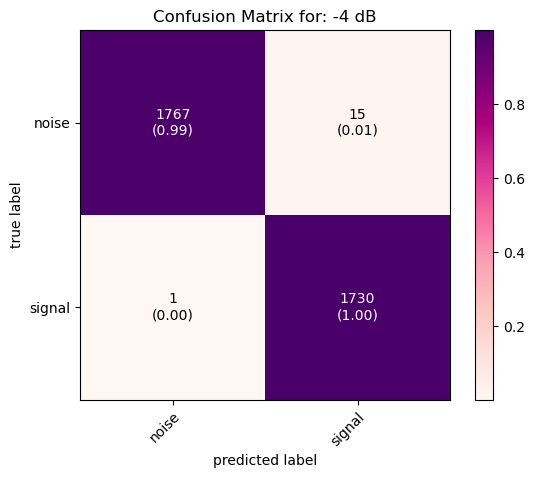

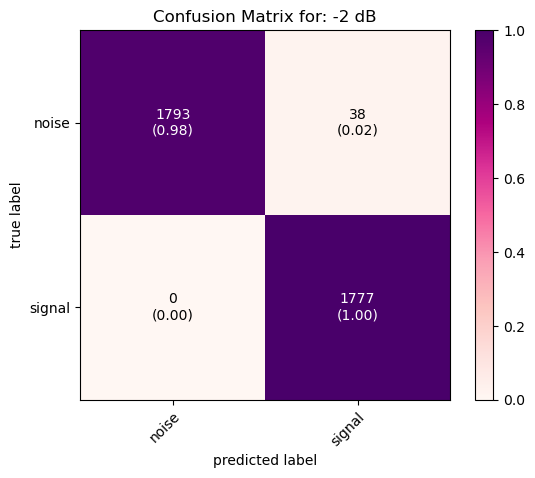

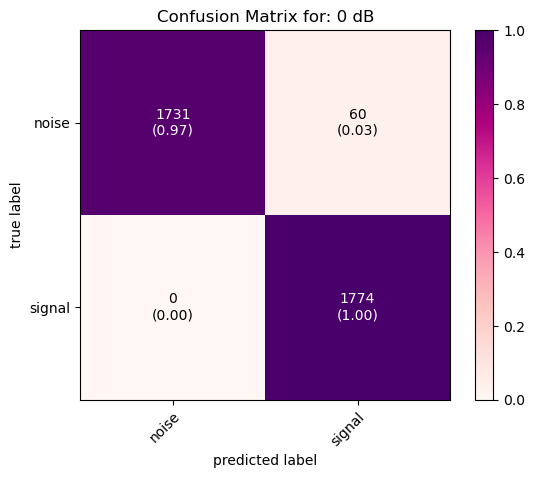

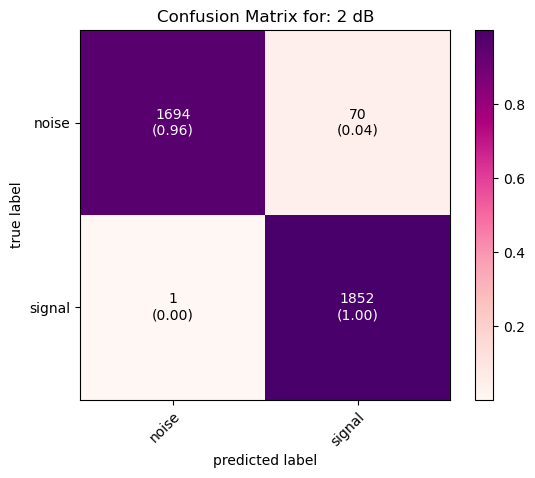

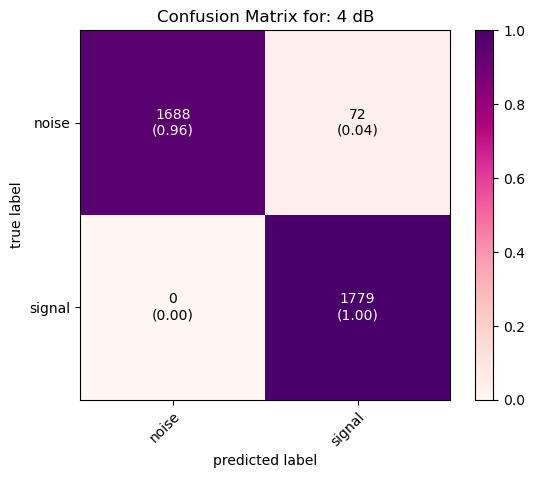

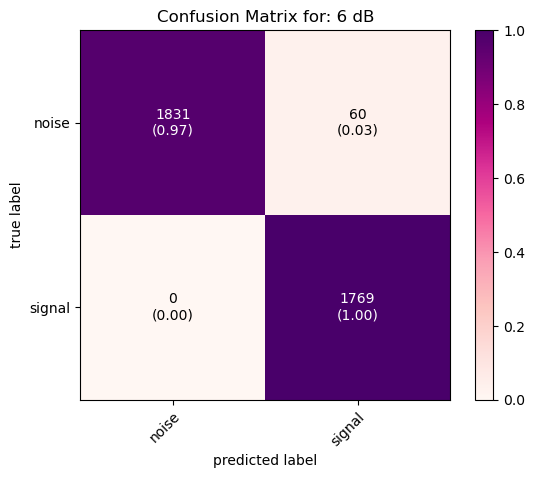

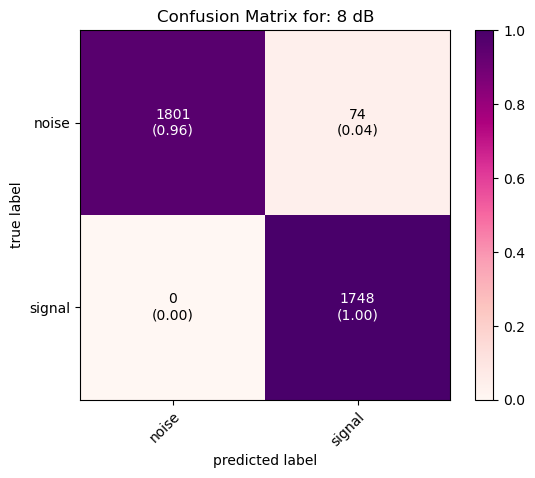

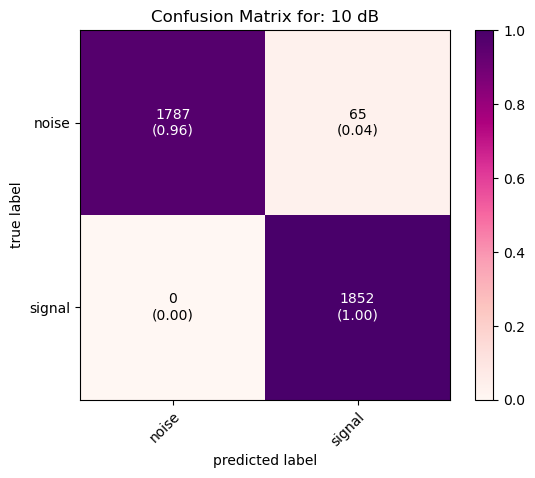

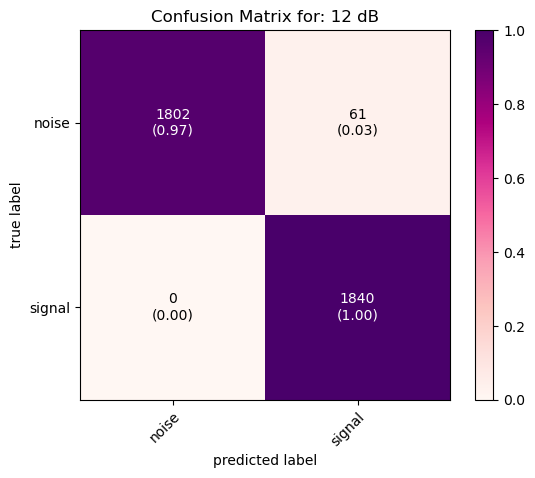

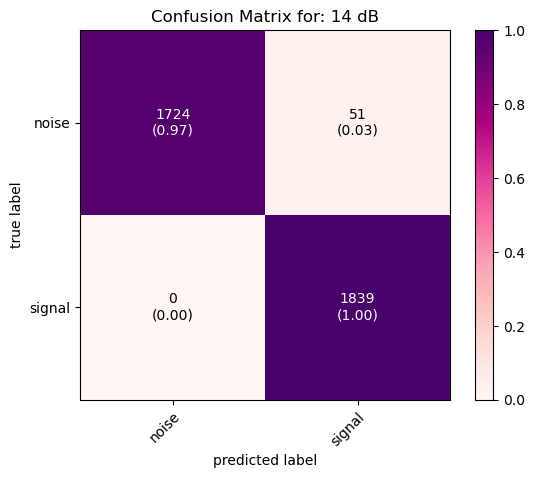

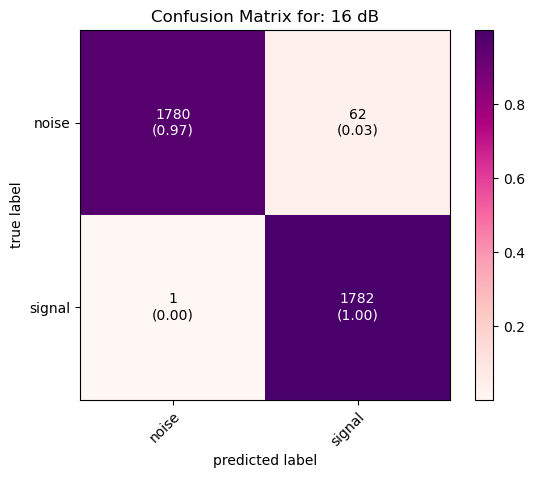

In [49]:
snr = [-20, -16, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16]
for i in range(len(snr)):
    pred_cm = []
    true_cm = []
    for k in range(len(data_snr)):
        if(data_snr['SNR'][k] == snr[i]):
           pred_cm.append(data_snr['prediction'][k])
           true_cm.append(data_snr['labels'][k])
    cm = confusion_matrix(true_cm, pred_cm)
    class_names = ['noise','signal']
    fig, ax = plot_confusion_matrix(conf_mat=cm, cmap = 'RdPu', class_names = class_names , colorbar=True , show_normed= True)
    plt.title(f"Confusion Matrix for: {snr[i]} dB")
    plt.show()